# Guided Activity Three
## Orbital Motion

Round three with Python! 

We will be building a model of orbital motion. This is the first time we will be applying the euler method in more than a single dimension. Let's again try to enfore code re-use: we may need to generalize our alorithms to accept tuples?

As usual, we start with imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def gravitational_acceleration(x, v, m, M=5.972e24, G=6.67408e-11):
    ''' Return x and y components of acceleration due to gravitity.
    
        Uses:
                    G * m * M / r**2
                    
        Args:
            G (float):   gravitational constant (m**3/(kg * s**2)))
            M (float):   mass of larger object (kg; default is Earth)
            m (float):   mass of smaller object (kg)
            x (float):   x distance from larger object (m)
            y (float):   y distance from larger object (m)
        
        Return:
            [float, float]: direction vector
    '''
    
    r = np.sqrt(np.sum(x**2))
    a = -1 * (G * M / (r*r*r)) * x
    
    return a

Now let's reuse the Euler method from our last excercise, being careful to make sure it will accept array inputs. Let's try and really tear up this function. I want to write it in super fast numpy arrays.

In [8]:
def euler_method(acceleration, t0, tf, dt, x0=0, v0=0, modified=False, **kwargs):
    ''' Returns t, x, v, and a lists for Modified Euler Method

        Args:
            acceleration (func):  a function that accepts x, v, and **kwargs and 
                                      return acceleration.
            t0 (float):           initial time (s)
            tf (float):           final time (s)
            dt (float):           time step (s)
            x0 (float):           initial displacement, downwards positive (m)
            v0 (float):           intiial velocity, downwards positive (m/s)
            **kwargs:             any additional arguments required for the 
                                      accleration function

            modified (bool):	turns on modified euler method.
            verbose (bool):		turns on printing of each time-step.

        Returns:
            float (list): lisf times (s)
            float (list): list of positions, downwards positive (m)
            float (list): list of velocities, downwards positive (m/s)
            float (list): list of acceleration, downwards positive (m/s**2)
    '''

    t = np.arange(start=t0, stop=tf, step=dt, dtype=np.float64)
    
    x = np.empty([t.size, 2])
    v = np.empty([t.size, 2])
    a = np.empty([t.size, 2])
    
    x[0] = x0
    v[0] = v0
    a[0] = acceleration(x0, v0, **kwargs)

    for i in range(1, t.size):
        a[i] = acceleration(x[i-1], v[i-1], **kwargs)
        
        if modified:
            v[i] = v[i-1] + dt * a[i]
            x[i] = x[i-1] + dt * v[i]
        else:        
            x[i] = x[i-1] + dt * v[i-1]
            v[i] = v[i-1] + dt * a[i]
        
    return t, x, v, a

For style points, I will use the `PyEphem` library to grab the current location and velocity of the moon for x0 and v0.

In [11]:
import ephem



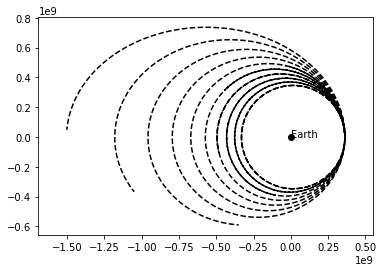

In [9]:
for mult in list(np.linspace(1, 1.3, 10)):
    x0 = np.asarray([363104000, 0], dtype=np.float64)
    v0 = np.asarray([0, 1023 * mult], dtype=np.float64)
    m = 100

    t, x, v, a = euler_method(gravitational_acceleration,
                                x0 = x0,
                                v0 = v0,
                                t0 = np.asarray(0.0, dtype=np.float64),
                                tf = np.asarray(60*60*24*50, dtype=np.float64),
                                dt = np.asarray(60*30, dtype=np.float64),
                                modified=True,
                                m=m)

    plt.plot(x[:,0], x[:,1], color='black', linestyle='--')
    
plt.plot(0, 0, marker='o', color='black')
plt.annotate('Earth', (0,0))
plt.axis('equal')
plt.show()